# MIRI PSF Photometry #1 - F560W PSF Photometry (Made Simple)

**Author**: Ori Fox
<br>
**Last Updated**: March, 2023

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
    3.1 [Display image](#display_data)<br>
    3.2 [Convert image units and apply pixel area map](#convert_data)<br>
4. [Create a synthetic PSF model (with WebbPSF)](#webbpsf_intro)<br>
    4.1 [Create the single PSF](#single_webbpsf)<br>
    4.2 [Display the single PSF](#display_single_webbpsf)<br>
    4.3 [Create the grid of PSFs](#grid_webbpsf)<br>
    4.4 [Display the grid of PSFs](#display_grid_webbpsf)<br>
5. [Create the PSF model building an effective PSF](#epsf_intro)<br>
    5.1 [Calculate the background](#bkg)<br>
    5.2 [Find sources in the image](#find)<br>
    5.3 [Select sources](#select)<br>
    5.4 [Create catalog of selected sources](#create_cat)<br>
    5.5 [Build the effective PSF](#build_epsf)<br>
    5.6 [Display the effective PSF](#display_epsf)<br>
6. [Perform PSF Photometry](#psf_phot)<br>
    6.1 [PSF photometry output catalog](#psf_cat)<br>
    6.2 [Display residual images](#residual)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: MIRI simulated images obtained using [MIRISIM](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of Isochrone of 10-Gyr old population, [Fe/H]=-1 Population placed at 2.5 kpc from the Sun. Salpeter-like IMF, tweaked to have more massive stars (since positions are random, it ensures at least a few bright stars in each image). Kept only sources brighter than J=17 (random cut to speed up MIRISim) and fainter than Ks=10 (to avoid too-bright stars that would have PSF spikes clearly cut by MIRISim in the image)

Here is the [ReadMe](https://stsci.app.box.com/s/2b6evrie2swaybarxhdmpqizktl3g0wm/file/869444882607). All data simulations can be found on [STScI's simulation page](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data).

PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
%matplotlib inline

In [2]:
import sys,os,glob
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

import st_phot

# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags

# Background and PSF Functions
#
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


<div class="alert alert-block alert-info">

**Note on pysynphot**: Data files for pysynphot are distributed separately by Calibration Reference Data System. They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.
    
<div >

### 2.2<font color='white'>-</font>Plot Settings<a class="anchor" id="matpl_imports"></a> ###

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

### 2.3<font color='white'>-</font>PSF FWHM dictionary<a class="anchor" id="psf_fwhm"></a> ###

The dictionary contains the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for the FWHM will be available for each detectors after commissioning.

In [4]:
filters = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

psf_fwhm = [1.636, 2.187, 2.888, 3.318, 3.713, 4.354, 5.224, 5.989, 7.312] #pixls

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

### 2.4 Useful Functions

In [5]:
def imshow_me_wcolorbar(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to show an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots()
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    plt.tight_layout()
    
    return

In [6]:
def imshow_me_wcolorbar_setup(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to setup an image to show. Similar to imshow_me_wcolorbar,
    but it does not show the image directly, thus allowing to plot
    something else after the call.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    
    return

In [7]:
def arcsec2pix(x):
    '''
    Function that converts arcsec in MIRIM pixels.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in arcsec.
        
    Outputs
    ----------
    The value(s) in MIRIM pixel.
    '''
    
    return x/0.11

In [8]:
def pix2arcsec(x):
    '''
    Function that converts MIRIM pixels in arcsec.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in MIRIM pixels.
        
    Outputs
    ----------
    The value(s) in arcsec.
    '''
    
    return x*0.11

These last three functions will be used to speed-up the exercise.

We adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image (The background is calculated using a mode estimator of the form `(3 * median) - (2 * mean)`). 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg = True` and use a more complex algorithm that takes into account those issues.

3.<font color='white'>-</font>Prepare Data <a class="anchor" id="load"></a>
------------------

### 3.1 Download Data

In [9]:
obs_table = Observations.query_criteria(proposal_id='01171',filters = ['F560W','F770W'])
data_products_by_obs = Observations.get_product_list(obs_table)
#data_products_by_obs = data_products_by_obs[data_products_by_obs['instrument_name']=='MIRIMAGER']
#data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
#data_products_by_obs

**Examine the first Image**

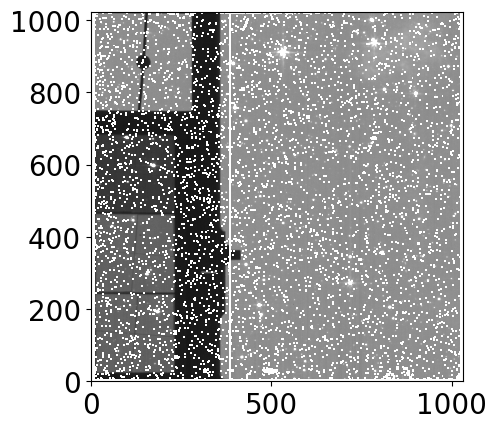

In [10]:
files = glob.glob('mastDownload/JWST/*/*cal.fits')
ref_image = files[0]
im = fits.open(ref_image)
w = wcs.WCS(im['SCI',1],im)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='linear',min_cut=-1,max_cut=10)

plt.imshow(ref_data, origin='lower', norm=norm1, cmap='gray')
#plt.gca().tick_params(labelcolor='none',axis='both',color='none')
#plt.show()

**Now display the image in Imviz**

To check that our image does not present artifacts and can be used in the analysis, we display it. 

### 3.2 Data Quality (DQ) Flags

Not all pixels should be used. We can use the Data Quality (DQ) flags to assess whether a pixel can be considered in calculations or not. [Here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags) you can find a description of the DQ flags.

There is no one-size-fits-all solution for selecting pixels using the DQ flags. For this specific exercise, let's keep all pixels with DQ flag equal to:

- 0 = Good pixel
- 2 = Pixel saturated during integration
- 4 = Jump detected during integration
- 6 = Combination of DQ flags 2 and 4

As we can see, the DQ flags can correspond to multiple features. We can use _dqflags.dqflags_to_mnemonics_ to convert the DQ integer values into more user-friendly names:

In [11]:
print(r' DQ flag equal to 2: {0}'.format(dqflags.dqflags_to_mnemonics(2, dqflags.group)))
print(r' DQ flag equal to 4: {0}'.format(dqflags.dqflags_to_mnemonics(4, dqflags.group)))
print(r' DQ flag equal to 6: {0}'.format(dqflags.dqflags_to_mnemonics(6, dqflags.group)))

 DQ flag equal to 2: {'SATURATED'}
 DQ flag equal to 4: {'JUMP_DET'}
 DQ flag equal to 6: {'JUMP_DET', 'SATURATED'}


Let's flag all pixels with a DQ flag different from these four values:

In [12]:
ok = np.zeros(im[1].data.shape, dtype='int')
for v in [0, 2, 4, 6]:
    ok = ok + np.where(im[3].data == v, 1, 0)

im[1].data[ok == 0] = np.nan
print(r'{0} out of {1} pixels are not usable (~{2:3.1f}%)'.format((ok == 0).sum(), im[1].data.shape[0]*im[1].data.shape[1], 
                                                                            (ok == 0).sum()/(im[1].data.shape[0]*im[1].data.shape[1])*100.0))

324093 out of 1056768 pixels are not usable (~30.7%)


Third extension is the DQ flags
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#rate

As we can notice, the regions associated to the 4-quadrant phase mask (4QPM) coronagraphs disappeared from the image. The optical system of the 4QPM coronographs is different from that of the imager. Because of the way these optical elements affect the light transmission, the calibration of the 4QPM-coronograph regions is complicated and specific for these coronographs. Therefore, even though photons are detected in the regions of the coronagraphs during standard imaging observations, these regions should not be used while analyzing the Stage-2 image. If you run the _calwebb_image3_ pipeline (or the resample step in _calwebb_image2_), you will notice that the 4QPM regions are missing in the resampled image (_i2d.fits_) as well.

Another feature we can notice is that two columns (# 385 and 386) were flagged. Although a qualitative assessment of the image (for example with ds9) does not show anything particularly different from the other columns, these two columns showed to be coupled and should not be used for science.

### 3.3<font color='white'>-</font>Convert image units and apply pixel area map<a class="anchor" id="convert_data"></a> ###

The unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to DN/s.

For images that have not been transformed into a distortion-free frame (i.e. not drizzled), a correction must be applied to account for the different on-sky pixel size across the field of view. A pixel area map (PAM), which is an image where each pixel value describes that pixel's area on the sky relative to the native plate scale, is used for this correction. In the stage 2 of the JWST pipeline, the PAM is copied into an image extension called **AREA** in the science data product. 

4.<font color='white'>-</font>Find Stars<a class="anchor" id="epsf_intro"></a>
------------------

More information on the PhotUtils Effective PSF can be found [here](https://photutils.readthedocs.io/en/stable/epsf.html).

The process of creating an effective PSF can be summarized as follows:

* Find the stars in the image.
* Select the stars we want to use for building the effective PSF. 
* Build the effective PSF.

### 4.1<font color='white'>-</font>Define Background Calculation<a class="anchor" id="bkg"></a> ###

We adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image (The background is calculated using a mode estimator of the form `(3 * median) - (2 * mean)`). 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg = True` and use a more complex algorithm that takes into account those issues.

In [13]:
def calc_bkg(file, var_bkg=False):
    
    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()
#    file = './data/jw01171001001_02101_00004_mirimage_i2d.fits'
    im = fits.open(file)

    if var_bkg:
        print('Using 2D Background')
        sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
        #coverage_mask = (data == 0)
        
        # Mask all nan or inf pixels
        coverage_mask = np.full(np.shape(im[1].data), False, dtype=bool)
        coverage_mask[np.isnan(im[1].data)] = True
        coverage_mask[~np.isfinite(im[1].data)] = True

        bkg = Background2D(data, (20, 20), filter_size=(30, 30), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        #_, _, std = sigma_clipped_stats(data_bkgsub)
        std = bkg.background_rms_median

    else:

        std = bkgrms(im[1].data)
        bkg = mmm_bkg(im[1].data)

        data_bkgsub = im[1].data.copy()
        data_bkgsub -= bkg

    return data_bkgsub, std

### 4.2<font color='white'>-</font>Find sources in the image<a class="anchor" id="find"></a> ###

To find sources in the image, we use the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) function. 

[DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) detects stars in an image using the DAOFIND ([Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) algorithm. DAOFIND searches images for local density maxima that have a peak amplitude greater than `threshold` (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel.

**Important parameters**:

* `threshold`: The absolute image value above which to select sources.
* `fwhm`: The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

In [14]:
def find_stars(file, det='MIRIM', filt='F770W', threshold=5, var_bkg=False):
    
    print('Finding stars --- Detector: {d}, Filter: {f}'.format(f=filt, d=det))

    sigma_psf = dict_utils[filt]['psf fwhm']

    print('FWHM for the filter {f}:'.format(f=filt), sigma_psf, "px")
    
    data_bkgsub, std = calc_bkg(file=file, var_bkg=var_bkg)
    
    daofind = DAOStarFinder(threshold=threshold * std, fwhm=sigma_psf, exclude_border=True)
    found_stars = daofind(data_bkgsub)
    
    print('')
    print('Number of sources found in the image:', len(found_stars))
    print('-------------------------------------')
    print('')
    
    return data_bkgsub, found_stars

In [15]:
det = 'MIRIM'
filt = 'F560W'

#file = './data/jw01171001001_02101_00004_mirimage_i2d.fits'
#im = fits.open(file)
#hdr560 = im["SCI",1].header
#w560 = WCS(im["SCI",1].header)

In [16]:
tic = time.perf_counter()

data_bkgsub, found_stars = find_stars(file=ref_image, det=det, filt=filt, threshold=2, var_bkg=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

Finding stars --- Detector: MIRIM, Filter: F560W
FWHM for the filter F560W: 1.636 px

Number of sources found in the image: 882
-------------------------------------

Elapsed Time for finding stars: 0.3654237090013339


In [17]:
# Print 10 lines of the table
found_stars.pprint_all(max_lines=10)

 id     xcentroid          ycentroid          sharpness       roundness1      roundness2      npix sky         peak               flux                mag         
--- ------------------ ------------------ ------------------ ----------- -------------------- ---- --- ------------------- ------------------ --------------------
  1  602.1100095355987   8.58687663479409  0.666967815971802   0.3695821  0.21296499247138861   25 0.0   5.944390296936035  13.08010482788086  -2.7915280614208844
  2 173.98812428293803  9.978570794222575 0.9787685159390548 -0.11267231   0.3616790111205072   25 0.0  -5.979526042938232 1.6056089401245117  -0.5140994441581106
  3  776.2282749180242  9.681640640222868 0.6035722155698251 -0.52114826 -0.10251653761726193   25 0.0 -0.7643156051635742 2.1257665157318115  -0.8187889048216945
...                ...                ...                ...         ...                  ...  ... ...                 ...                ...                  ...
880  419.2663081136069

The column description is almost straightforward. The three parameters that need further description are:
- sharpness : (height of the central pixel - mean of the surrounding non-bad pixels) / (height of the best fitting Gaussian function at that point);
- roundness1 : source symmetry;
- roundness2 : (difference in the height of the best fitting Gaussian function in x - the height of the the best fitting Gaussian function in y) / (average of the best fitting Gaussian functions in x and y).

These parameters can be used to discern between stars, galaxies or spurious detections. It is possible to setup _DAOStarFinder_ to exclude a priori objects outside a specific range of sharpness/roundness1/roundness2. Finally, note that the magnitude is defined as $-2.5\log_{10}(\text{peak density/detection threshold})$, which is just a rough estimate of the magnitude. An exaustive description of inputs and outputs is also provided [here](https://iraf.net/irafhelp.php?val=daofind).

Let's plot what we have found. We can use _imshow_me_wcolorbar_setup_, which is a function similar to _imshow_me_wcolorbar_ we used before but it allows us to keep plotting.

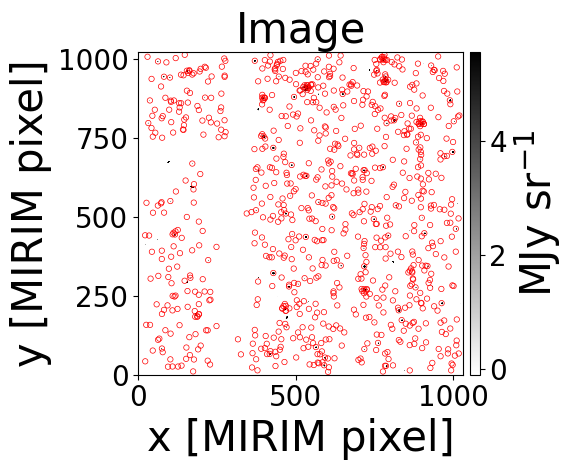

In [18]:
fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(data_bkgsub, -0.1, 5.55, 'Image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(found_stars['xcentroid'], found_stars['ycentroid'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
plt.tight_layout()

### 4.3<font color='white'>-</font>Select sources<a class="anchor" id="select"></a> ###

At the beginning, we used the DQ flags to mask some pixels and kept only those with DQ$=$0, 2, 4, 6. Although still perfectly usable, you might want to keep track of pixels that saturated during an integration or were hit by a cosmic ray. For this reason, we define a flag by checking all pixels within each aperture radius we used:

In [19]:
found_stars['flags'] = np.zeros(len(found_stars), dtype=int)

rad = 5.

for s in found_stars:
        jmin = max(1, int(np.floor(s['ycentroid']-rad)))
        jmax = min(round(s['ycentroid']+rad)+1, im[1].shape[0])
        imin = max(1, int(np.floor(s['xcentroid']-rad)))
        imax = min(round(s['xcentroid']+rad)+1, im[1].shape[1])
        if (np.sum(im[3].data[jmin:jmax, imin:imax] == 6) > 0):
            s['flags'] = 6
        elif (np.sum(im[3].data[jmin:jmax, imin:imax] == 2) > 0):
            s['flags'] = 2
        elif (np.sum(im[3].data[jmin:jmax, imin:imax] == 4) > 0):
            s['flags'] = 4
            
print('                            Sources found: {0}'.format(len(found_stars)))
print('Sources with "SATURATED" pixels within rad=5: {0}'.format(np.sum(np.logical_or(found_stars['flags'] == 2, found_stars['flags'] == 6))))
print(' Sources with "JUMP_DET" pixels within rad=5: {0}'.format(np.sum(np.logical_or(found_stars['flags'] == 4, found_stars['flags'] == 6))))

                            Sources found: 882
Sources with "SATURATED" pixels within rad=5: 0
 Sources with "JUMP_DET" pixels within rad=5: 780


Let's check if our flag works. For example, let's test the jump-detection flag:

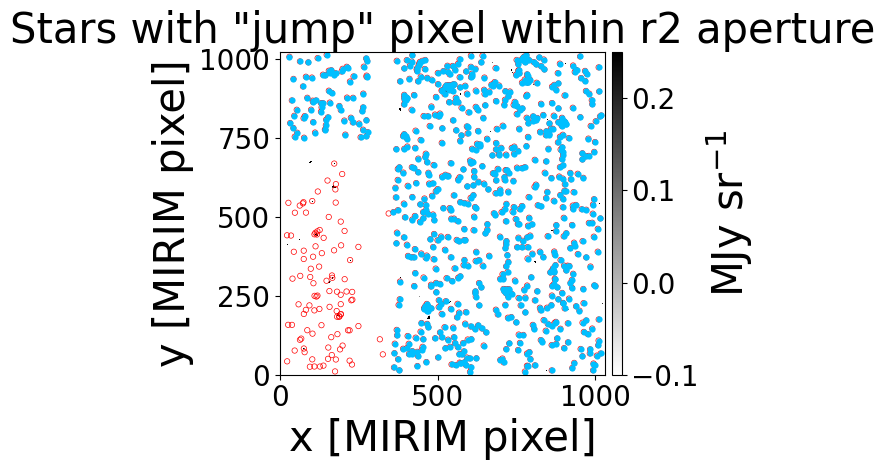

In [20]:
# Flag for stars with "jump" pixel within rad=5 aperture
jump = np.logical_or(found_stars['flags'] == 4, found_stars['flags'] == 6)

fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(data_bkgsub, -0.1, 0.25, 'Stars with "jump" pixel within r2 aperture', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(found_stars['xcentroid'], found_stars['ycentroid'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
ax.scatter(found_stars['xcentroid'][jump], found_stars['ycentroid'][jump], c='deepskyblue', lw=0, s=20)
plt.tight_layout()

We can adopt different methods to select sources we want to use to build an effective PSF. Here, we select objects applying a brightness cut (we do not want to include objects that are too faint) and using the `roundness2` and `sharpness` parameters provided in the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) output catalog.

`roundness2` measures the ratio of the difference in the height of the best fitting Gaussian function in x minus the best fitting Gaussian function in y, divided by the average of the best fitting Gaussian functions in x and y.

`sharpness` measures the ratio of the difference between the height of the central pixel and the mean of the surrounding non-bad pixels in the convolved image, to the height of the best fitting Gaussian function at that point.

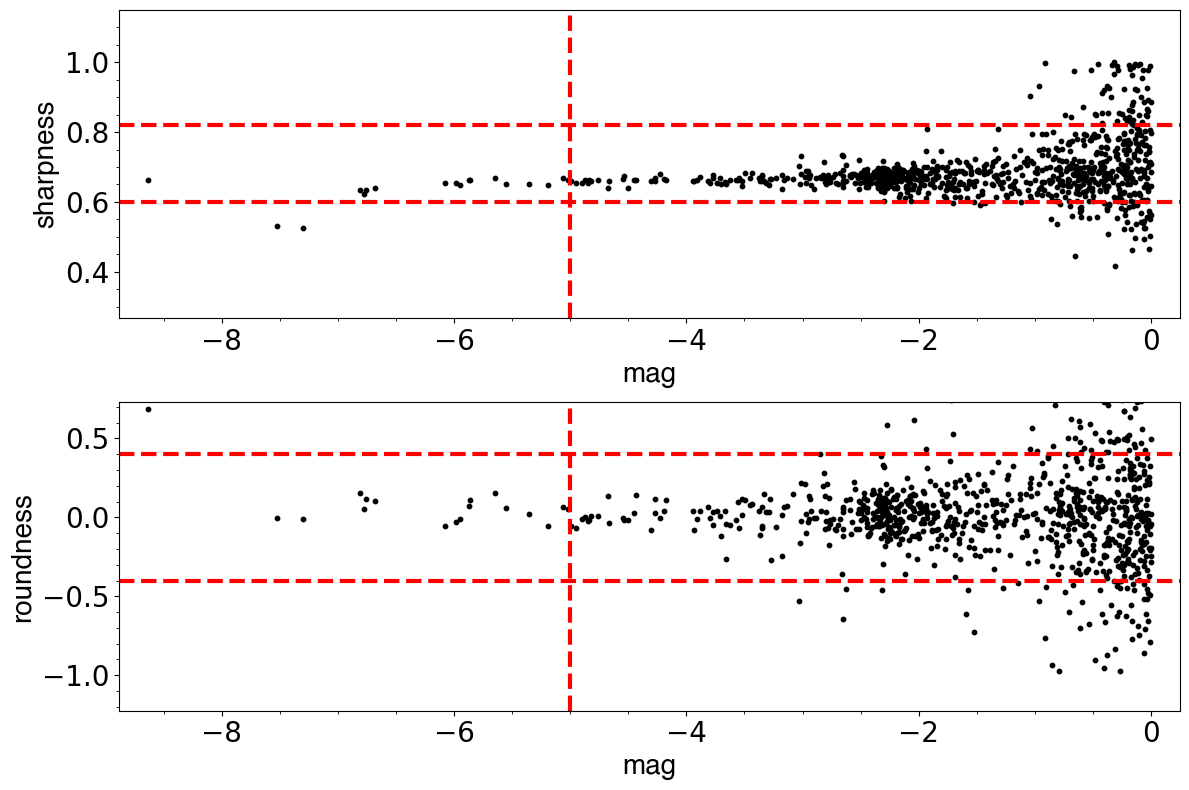

In [21]:
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.60
sh_sup = 0.82
mag_lim = -5.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

### 4.4<font color='white'>-</font>Create catalog of selected sources<a class="anchor" id="create_cat"></a> ###

We can also include a separation criteria if we want to retain in the final catalog only the stars that are well isolated. In particular, we can select only the stars that do not have a neighbour closer than X pixel, where X is a parameter that can be set manually.

**Note**: The magnitude limit and the minimum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, minimum number of stars required to build the ePSF, etc.) and must be modified accordingly.

In [22]:
mask = ((found_stars['mag'] < mag_lim) & (found_stars['roundness2'] > round_inf)
        & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf) 
        & (found_stars['sharpness'] < sh_sup))

found_stars_sel = found_stars[mask]
found_stars_sel_f560w = found_stars_sel

print('Number of stars selected to build ePSF:', len(found_stars))
print('Number of stars selected to build ePSF:', len(found_stars_sel))

# if we include the separation criteria:

d = []

# we do not want any stars in a 10 px radius. 

min_sep = 10

x_tot = found_stars['xcentroid']
y_tot = found_stars['ycentroid']

for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

    sep = []
    dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
    sep = np.sort(dist)[1:2][0]
    d.append(sep)

found_stars_sel['min distance'] = d
mask_dist = (found_stars_sel['min distance'] > min_sep)

found_stars_sel2 = found_stars_sel[mask_dist]
found_stars_sel2_fw = found_stars_sel2

print('Number of stars selected to build ePSF \
including "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

Number of stars selected to build ePSF: 882
Number of stars selected to build ePSF: 15
Number of stars selected to build ePSF including "mimimum distance closest neighbour" selection): 5


In [23]:
found_stars_sel

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,flags,min distance
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64,int64,float64
51,416.9336599061582,65.61092221343299,0.6694090328756354,0.3034528,0.15313830967181336,25,0.0,107.26644897460938,181.4491729736328,-5.646887482680565,4,8.422561156540846
168,826.2750486917845,203.9415637472265,0.6549231271832737,-0.01716909,-0.026986032080375765,25,0.0,143.74038696289062,247.8142852783203,-5.985315844272105,4,8.462984066586154
237,478.11323488426734,279.4589838908811,0.661328875605493,0.16164932,0.05015549825853978,25,0.0,60.331756591796875,101.92125701904297,-5.02066192820296,4,5.522634542999792
272,428.33358003224885,322.2091270783511,0.6489428537141332,0.15117739,-0.012034801777839284,25,0.0,139.37779235839844,240.02528381347656,-5.9506424797197965,4,29.95849041771145
284,716.7775503004706,343.4377780721307,0.6614643552420637,-0.042030603,0.10736903958057298,25,0.0,130.44369506835938,221.5884552001953,-5.863867824555933,4,15.597759267366628
363,116.27343354996931,444.5118387855751,0.6518299764205235,0.18055387,0.022095816544879177,25,0.0,84.59603118896484,138.1952667236328,-5.351232921072102,0,7.061641870666557
557,996.3117258143146,706.5494457959466,0.668090542272273,-0.107004695,0.06630557606243795,25,0.0,61.597129821777344,105.5506820678711,-5.058652610152665,4,21.244761516152447
566,428.2305897181322,719.3490284693172,0.6519602109149542,0.18185365,0.06189901560515496,25,0.0,97.03981018066406,166.8902587890625,-5.556077470253818,4,25.38211700975615
591,397.8447110428186,755.6886368540733,0.6229846988448969,0.11308718,0.05148916881169865,25,0.0,305.3365173339844,513.5556030273438,-6.776468679622143,4,8.192841813302202


#### Save File

5.<font color='white'>-</font>Perform PSF Photometry<a class="anchor" id="psf_phot"></a>
------------------

For general information on PSF Photometry with PhotUtils see [here](https://photutils.readthedocs.io/en/stable/psf.html). 

Photutils provides three classes to perform PSF Photometry: [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), [IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry), and [DAOPhotPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOPhotPSFPhotometry.html#photutils.psf.DAOPhotPSFPhotometry). Together these provide the core workflow to make photometric measurements given an appropriate PSF (or other) model.

[BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry) implements the minimum tools for model-fitting photometry. At its core, this involves finding sources in an image, grouping overlapping sources into a single model, fitting the model to the sources, and subtracting the models from the image. In DAOPHOT parlance, this is essentially running the “FIND, GROUP, NSTAR, SUBTRACT” once.

[IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry) (adopted here) is similar to [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), but it adds a parameter called `n_iters` which is the number of iterations for which the loop “FIND, GROUP, NSTAR, SUBTRACT, FIND…” will be performed. This class enables photometry in a scenario where there exists significant overlap between stars that are of quite different brightness. For instance, the detection algorithm may not be able to detect a faint and bright star very close together in the first iteration, but they will be detected in the next iteration after the brighter stars have been fit and subtracted. Like [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), it does not include implementations of the stages of this process, but it provides the structure in which those stages run.

**Important parameters**:

* `finder`: classes to find stars in the image. We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html).

* `group_maker`:  clustering algorithm in order to label the sources according to groups. We use [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup). The method group_stars divides an entire starlist into sets of distinct, self-contained groups of mutually overlapping stars. It accepts as input a list of stars and determines which stars are close enough to be capable of adversely influencing each others’ profile fits. [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup) aceepts one parameter, `crit_separation`, which is the distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

* `fitter`: algorithm to fit the sources simultaneously for each group. We use an astropy fitter, [LevMarLSQFitter](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LevMarLSQFitter.html#astropy.modeling.fitting.LevMarLSQFitter). 

* `niters`: number of iterations for which the "psf photometry" loop described above is performed.

* `fitshape`: Rectangular shape around the center of a star which will be used to collect the data to do the fitting. 

* `aperture_radius`: The radius (in units of pixels) used to compute initial estimates for the fluxes of sources.

### 5.1<font color='white'>-</font>Calculate Background<a class="anchor" id="background"></a> ###

##### Standard Background Calculation

In [24]:
bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
    
std = bkgrms(im[1].data)
bkg = mmm_bkg(im[1].data)

data_bkgsub = im[1].data.copy()
data_bkgsub -= bkg

std

0.12916438852779746

##### 2D Variable Background Calculation

### 5.2<font color='white'>-</font>Perform Photometry<a class="anchor" id="background"></a> ###

fitter = LevMarLSQFitter()
mmm_bkg = MMMBackground()
th = 5.
ap_radius=6.
        
sigma_psf = dict_utils[filt]['psf fwhm']
print('FWHM for filter {f}:'.format(f=filt), sigma_psf*2)
    
daofind = DAOStarFinder(threshold=th * std, fwhm=sigma_psf)
daogroup = DAOGroup(5.0 * sigma_psf)
    
psf_model = epsf.copy()
    
print('Performing the PSF photometry')
tic = time.perf_counter()
    
phot = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                                            bkg_estimator=mmm_bkg, psf_model=psf_model,
                                            fitter=fitter,
                                            niters=10, fitshape=(15, 15), aperture_radius=ap_radius, 
                                            extra_output_cols=('sharpness', 'roundness2'))
psf_phot_results = phot(data)
toc = time.perf_counter()
    
print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
print('Number of sources detected:', len(psf_phot_results))
        
residual_image = phot.get_residual_image()
    
# save the residual images as fits file:
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])
    
residual_outname = 'residual_MIRIM_F560W.fits'
hdul.writeto(os.path.join(res_dir, residual_outname),overwrite=True)

# save the output photometry Tables
outname = 'phot_MIRIM_F560W.pkl'
tab = psf_phot_results.to_pandas()
tab.to_pickle(os.path.join(output_phot_dir, outname))

In [25]:
from astropy.wcs.utils import skycoord_to_pixel

sky = w.pixel_to_world(found_stars_sel['xcentroid'], found_stars_sel['xcentroid'])
sky[0]

<SkyCoord (ICRS): (ra, dec) in deg
    (80.46686739, -69.50458908)>

**Get the PSF model**

st_phot uses WebbPSF models for JWST. This can be pretty slow, 
so you don't want to run this every time. Either create your
own repository of these and pass each one when needed directly to
the psf_photometry function, or else at least just do this once,
save the ouptut, and then read it in and proceed to photometry
for testing purposes.

## For Justin: Need to sort by filter

In [26]:
files

['mastDownload/JWST/jw01171001001_02101_00004_mirimage/jw01171001001_02101_00004_mirimage_cal.fits',
 'mastDownload/JWST/jw01171003001_02101_00001_mirimage/jw01171003001_02101_00001_mirimage_cal.fits',
 'mastDownload/JWST/jw01171002001_02101_00003_mirimage/jw01171002001_02101_00003_mirimage_cal.fits',
 'mastDownload/JWST/jw01171002001_02101_00002_mirimage/jw01171002001_02101_00002_mirimage_cal.fits',
 'mastDownload/JWST/jw01171005001_02101_00004_mirimage/jw01171005001_02101_00004_mirimage_cal.fits',
 'mastDownload/JWST/jw01171005001_02101_00003_mirimage/jw01171005001_02101_00003_mirimage_cal.fits',
 'mastDownload/JWST/jw01171005001_02101_00002_mirimage/jw01171005001_02101_00002_mirimage_cal.fits',
 'mastDownload/JWST/jw01171004001_02101_00001_mirimage/jw01171004001_02101_00001_mirimage_cal.fits',
 'mastDownload/JWST/jw01171001001_02101_00002_mirimage/jw01171001001_02101_00002_mirimage_cal.fits',
 'mastDownload/JWST/jw01171001001_02101_00003_mirimage/jw01171001001_02101_00003_mirimage_c

In [41]:
# Sort files by filter

phot_files = ['mastDownload/JWST/jw01171004001_02101_00001_mirimage/jw01171004001_02101_00001_mirimage_cal.fits',
             'mastDownload/JWST/jw01171004001_02101_00002_mirimage/jw01171004001_02101_00002_mirimage_cal.fits',
             'mastDownload/JWST/jw01171004001_02101_00003_mirimage/jw01171004001_02101_00003_mirimage_cal.fits',
             'mastDownload/JWST/jw01171004001_02101_00004_mirimage/jw01171004001_02101_00004_mirimage_cal.fits']

In [43]:
sn_location

<SkyCoord (ICRS): (ra, dec) in deg
    (80.46686739, -69.50458908)>

In [45]:
sn_location = sky[0]
jwst_obs = st_phot.observation(phot_files)
psfs = st_phot.get_jwst_psf(jwst_obs,sn_location,num_psfs=4)
#plt.imshow(psfs[0].data)
#plt.show()


Running instrument: MIRI, filter: F560W
  Running detector: MIRIM
    Position 1/4: (0, 0) pixels
    Position 1/4 centroid: (201.39494494448837, 201.4682632048318)
    Position 2/4: (0, 1023) pixels
    Position 2/4 centroid: (201.30175844517584, 201.31980818321833)
    Position 3/4: (1023, 0) pixels
    Position 3/4 centroid: (201.42832432439775, 201.59923119926663)
    Position 4/4: (1023, 1023) pixels
    Position 4/4 centroid: (201.7551960209222, 201.49675780876905)


NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 2 iterations, the solution is diverging at least for one input point.

**Measure the PSF photometry**

## For Justin: PSFs need to be imported from a library rather than created

In [36]:
psfs

[<EPSFModel(flux=1., x_0=0., y_0=0.)>,
 <EPSFModel(flux=1., x_0=0., y_0=0.)>,
 <EPSFModel(flux=1., x_0=0., y_0=0.)>,
 <EPSFModel(flux=1., x_0=0., y_0=0.)>]

In [34]:
jwst_obs.psf_photometry(psfs,sn_location,bounds={'flux':[-3000,100],
                        'centroid':[-2,2],
                        'bkg':[0,50]},
                        fit_width=5,
                        fit_bkg=True,
                        fit_flux='single')
jwst_obs.plot_psf_fit()
plt.show()

jwst_obs.plot_psf_posterior(minweight=.0005)
plt.show()

print(jwst_obs.psf_result.phot_cal_table)

KeyboardInterrupt: 

### 5.3<font color='white'>-</font>PSF photometry output catalog (Currently Missing)<a class="anchor" id="psf_cat"></a> ###

In [ ]:
psf_phot_results

### 5.4<font color='white'>-</font>Display Residual Image (Currently Missing)<a class="anchor" id="residual"></a> ###

In [ ]:
#imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
imviz = Imviz()
imviz.app

In [ ]:
imviz.load_data(residual_image,data_label='Residual')
imviz.load_data(data,data_label='Original')
viewer = imviz.default_viewer
viewer.cuts = '95%'

In [ ]:
viewer_2_name='Window 2'
viewer_2 = imviz.create_image_viewer(viewer_name=viewer_2_name)

In [ ]:
imviz.app.add_data_to_viewer(viewer_2_name, 'Residual')

In [ ]:
viewer_2.cuts = '95%'

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>